## Хотим найти коэффициенты к каждому этапу, чтобы они итерационно подбирались

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/Users/timurkin/Desktop/курсач/данные_проекты.csv")

data_project = df

data_project = data_project[['Тема', 'Baseline PI план','PI (Факт)']]
data_project = data_project.rename(columns={'Baseline PI план': 'TPM', 'PI (Факт)': 'TSM'})
pos = [[5536, 5529, 5524, 5520], [2553, 2548, 2551, 2552, 2550], [2464, 2463, 2462, 2461, 2460]]

df
  
import numpy as np

def correlated_project_hours(mean, std, corr_matrix, n_stages=4):
    assert corr_matrix.shape == (n_stages, n_stages), "Корреляционная матрица должна иметь размер (4, 4)"
    hours = np.random.multivariate_normal(mean, corr_matrix * np.outer(std, std))
    return np.maximum(np.round(hours), 30).astype(int)  # Округляем значения и проверяем, что все значения неотрицательны

def generate_project_hours(num_projects, mean_std, corr_matrix):
    planned_hours = []
    spent_hours = []

    for _ in range(num_projects):
        project_planned_hours = correlated_project_hours(mean_std[:, 0], mean_std[:, 1], corr_matrix)
        
        # Введем зависимость между запланированными и затраченными часами
        spent_mean = project_planned_hours * np.random.uniform(0.9, 1.1, len(project_planned_hours))
        spent_std = mean_std[:, 1] * 0.5  # Увеличим дисперсию
        project_spent_hours = correlated_project_hours(spent_mean, spent_std, corr_matrix)

        planned_hours.append(project_planned_hours)
        spent_hours.append(project_spent_hours)

    return planned_hours, spent_hours

num_projects = 100

# Средние значения и стандартные отклонения для каждого этапа проекта с учетом неравномерного распределения
mean_std = np.array([
    (100, 50),  # Анализ
    (300, 150),  # Реализация
    (150, 70),  # Внедрение
    (50, 30)    # Завершение
])

# Корреляционная матрица между этапами проекта
corr_matrix = np.array([
    [1.0, 0.5, 0.4, 0.3],
    [0.5, 1.0, 0.6, 0.4],
    [0.4, 0.6, 1.0, 0.5],
    [0.3, 0.4, 0.5, 1.0]
])

planned_hours, spent_hours = generate_project_hours(num_projects, mean_std, corr_matrix)


for i in range (1, num_projects * 4 + 1, 4):
    array = list(range(i, i + 4))
    pos.append(array)
    
for i in range(3, len(pos)):
    for j in range(4):
        data_project.at[pos[i][j], 'TPM'] = planned_hours[i - 3][j]
        data_project.at[pos[i][j], 'TSM'] = spent_hours[i - 3][j]
        

data_project.iloc[pos[0]]
data_project['stage'] = 9
for i in range(0, 4):
    k = 1
    for j in pos[0]:
        data_project.at[j, 'stage'] = k
        k += 1
        
for i in range(0, 5):
    k = 1
    for j in pos[1]:
        data_project.at[j, 'stage'] = k
        k += 1
        
for i in range(0, 5):
    k = 1
    for j in pos[2]:
        data_project.at[j, 'stage'] = k
        k += 1
        
for i in range(0, 5):
    k = 1
    for j in pos[2]:
        data_project.at[j, 'stage'] = k
        k += 1

for i in pos:
    k = 1
    for j in i:
        data_project.at[j, 'stage'] = k
        k += 1
        
all_lines =  [item for sublist in pos for item in sublist]
data_filtered = data_project.iloc[all_lines]
data_filtered


,Тема,TPM,TSM,stage
5536,"PROV-747: 02.Анализ Блок ""Розница"" в БГУ 2.0",47.8,36.0,1
5529,"PROV-747: 03.Реализация Блок ""Розница"" в БГУ 2.0",27.4,19.0,2
5524,"PROV-747: 04.Внедрение Блок ""Розница"" в БГУ 2.0",21.2,22.0,3
5520,"PROV-747: 05.Завершение Блок ""Розница"" в БГУ 2.0",57.4,75.0,4
2553,PROV-4061: Концепция решения,20.0,19.0,1
...,...,...,...,...
396,UCS-919: Архитектура в проекте Поддержка Смарт...,58.0,54.0,4
397,UCS-919: Аналитика и тестирование в проекте П...,112.0,99.0,1
398,UCS-729: Приемка разработки: постановка задач...,54.0,78.0,2
399,UCS-729: Приемка разработки: постановка задач ...,30.0,30.0,3


In [2]:
def predict_stages(data_set, rows, stage, coefs):

    current = data_set.iloc[rows]
    current = current.set_index(pd.Index(range(0, len(rows), 1)))

    current['Total planned hours'] = current['TPM']
    for i in range(1, len(rows)):
        current['Total planned hours'][i] = current['Total planned hours'][i-1] + current["TPM"][i]

    S = pd.to_numeric(current['TSM'][0]) / pd.to_numeric(current['TPM'][0])
    current['Estimate_coef'] = S
    
    last_index = 1
    for i in range(1, stage):
        if pd.isna(current['TSM'][i]):
            last_index = i
            break
        last_index = i
        S += pd.to_numeric(current['TSM'][i]) / pd.to_numeric(current['TPM'][i])
        current['Estimate_coef'][i] = S
        current['Estimate_coef'][i] /= i + 1
        

    for i in range(last_index, len(rows)):
        current['Estimate_coef'][i] = current['Estimate_coef'][stage - 1]
        
        
    if len(rows) == 4:
        for i in range(stage + 1, len(coefs)):
            current['Estimate_coef'][i - 1] *= coefs[i]
    if len(rows) == 5:
        current['Estimate_coef'] *= coefs


    current['Estimate_hours'] = 1
    for i in range (0, len(rows)):
        current['Estimate_hours'][i] = current['Estimate_coef'][i] * current['TPM'][i]
    
    return current



In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

coefficients = [[], [], [], [], []]

for k in range(1, 4):
    A = []
    for lines in pos:
        A.append(predict_stages(data_project, lines, k, [1, 1, 1, 1, 1]))
    A = pd.concat(A)
#     print(A)
    for i in range(k + 1, 5):
        stage_data = data_filtered[data_filtered['stage'] == i]

        A1 = A.loc[A['stage'] == i, ['Estimate_hours']]
        
        X = A1.values.reshape(-1, 1)
        X = pd.DataFrame(X)
        X.fillna(0, inplace= True )
        y = stage_data['TSM']
        y = np.array(y).reshape(-1,1)
        X = np.array(X)
#         model = LinearRegression()
#         model.fit(X, y)
        model = LinearRegression().fit(y, X)
#         print(model.intercept_)
        y_pred = model.predict(X)
        
        result = y / y_pred
        coefficients[i].append(result.mean())

print("Коэффициенты для каждого этапа:", coefficients)

first_c = [1, 1] + [i[0] for i in coefficients[2:]]
second_c = [1, 1, 1] + [i[1] for i in coefficients[3:]]
third_c = [1, 1, 1, 1] + [i[2] for i in coefficients[4:]]


Коэффициенты для каждого этапа: [[], [], [1.0813327350013568], [1.475267449589899, 0.8427703747270461], [1.0723709336967955, 1.015126342371665, 1.0018518461331556]]


## Давайте теперь попробуем сделать графики предикта для каждого из этапов 

In [4]:
def make_predict_chart(data_project, position, first_c, second_c, third_c, project_lines):

    first_ff = predict_stages(data_project, pos[position], 1, first_c) 
    first = first_ff

    first_second_stage = predict_stages(data_project, pos[position], 2, second_c)
    first_third_stage = predict_stages(data_project, pos[position], 3, third_c)
    
    
    
    if len(pos[position]) == 5:
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    else:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    plan = [x for x in first['Total planned hours'].values]
    if (len(pos[position]) == 4):
        stages_4 = ['анализ', 'реализация', 'внедрение', 'завершение']
    else:
        stages_4 = ['инициация', 'анализ', 'реализация', 'внедрение', 'завершение']
    st = [0] + stages_4


    axs[0].plot([0, stages_4[0]], [0, first['TSM'][0]], label='текущий этап')

    est = []
    s = 0
    for x in first_ff['Estimate_hours']:
        s += x
        est.append(s)
    real = []
    s1 = 0
    for x in first['TSM']:
        s1 += x
        real.append(s1)
    axs[0].plot(stages_4, est, label='предсказание', linestyle='dashed')
    axs[0].plot(stages_4, est, 'ro', label='milestone')
    axs[0].plot(st, [0] + plan, label='план')
    axs[0].plot(stages_4, real, label='факт')
    axs[0].axvline(x=1, linestyle='dashed')
    axs[0].grid()
    axs[0].set_xlabel('номер майлстоуна')
    axs[0].set_ylabel('оценка на часы выполнения')
    axs[0].legend()
#     print(f"predict: {est[-1]}")
#     print(f"real: {real[-1]}")
    print(f"mistake: {abs(est[-1] - real[-1]) / real[-1] * 100}")


    axs[1].plot([0, stages_4[0], stages_4[1]], [0, first['TSM'][0], first['TSM'][0] + first['TSM'][1]], label='текущий этап')

    est = []
    s = sum(first['TSM'][0:2])
    est.append(s)
    for x in first_second_stage['Estimate_hours'][2:]:
        s += x
        est.append(s)

    real = []
    s1 = 0
    for x in first['TSM']:
        s1 += x
        real.append(s1)

    axs[1].plot(stages_4[1:], est, label='предсказание', linestyle='dashed')
    axs[1].plot(stages_4[1:], est, 'ro', label='milestone')
    axs[1].plot(st, [0] + plan, label='план')
    axs[1].plot(stages_4, real, label='факт')
    axs[1].axvline(x=2, linestyle='dashed')
    axs[1].grid()
    axs[1].set_xlabel('номер майлстоуна')
    axs[1].set_ylabel('оценка на часы выполнения')
    axs[1].legend()
#     print(f"predict: {est[-1]}")
#     print(f"real: {real[-1]}")
    print(f"mistake: {abs(est[-1] - real[-1]) / real[-1] * 100}")

    axs[2].plot([0, stages_4[0], stages_4[1], stages_4[2]], [0, first['TSM'][0], first['TSM'][0] + first['TSM'][1], first['TSM'][0] + first['TSM'][1] + first['TSM'][2]], label='текущий этап')

    est = []
    s = sum(first['TSM'][0:3])
    est.append(s)
    for x in first_second_stage['Estimate_hours'][3:]:
        s += x
        est.append(s)

    real = []
    s1 = 0
    for x in first['TSM']:
        s1 += x
        real.append(s1)

    axs[2].plot(stages_4[2:], est, label='предсказание', linestyle='dashed')
    axs[2].plot(stages_4[2:], est, 'ro', label='milestone')
    axs[2].plot(st, [0] + plan, label='план')
    axs[2].plot(stages_4, real, label='факт')
    axs[2].axvline(x=3, linestyle='dashed')
    axs[2].grid()
    axs[2].set_xlabel('номер майлстоуна')
    axs[2].set_ylabel('оценка на часы выполнения')
    axs[2].legend()
#     print(f"predict: {est[-1]}")
#     print(f"real: {real[-1]}")
    print(f"mistake: {abs(est[-1] - real[-1]) / real[-1] * 100}")
    
    
    
    if (len(pos[position]) == 5):
        pl = []
        s = 0
        for i in first['TSM']:
            pl.append(s)
            s += i
        axs[3].plot([0, stages_4[0], stages_4[1], stages_4[2], stages_4[3]], pl, label='текущий этап')

        est = []
        s = sum(first['TSM'][0:4])
        est.append(s)
        for x in first_second_stage['Estimate_hours'][4:]:
            s += x
            est.append(s)

        real = []
        s1 = 0
        for x in first['TSM']:
            s1 += x
            real.append(s1)

        axs[3].plot(stages_4[3:], est, label='предсказание', linestyle='dashed')
        axs[3].plot(stages_4[3:], est, 'ro', label='milestone')
        axs[3].plot(st, [0] + plan, label='план')
        axs[3].plot(stages_4, real, label='факт')
        axs[3].axvline(x=4, linestyle='dashed')
        axs[3].grid()
        axs[3].set_xlabel('номер майлстоуна')
        axs[3].set_ylabel('оценка на часы выполнения')
        axs[3].legend()
#         print(f"predict: {est[-1]}")
#         print(f"real: {real[-1]}")
        print(f"mistake: {abs(est[-1] - real[-1]) / real[-1] * 100}")




mistake: 19.49685534591195
mistake: 52.83018867924528
mistake: 51.57232704402516
mistake: 20.754716981132077


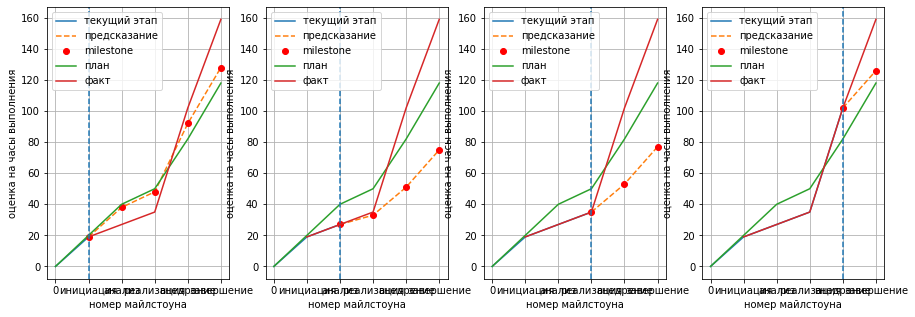

In [5]:
make_predict_chart(data_project, 1, first_c, second_c, third_c, pos)


mistake: 59.773202029245
mistake: 71.96657714115192
mistake: 2.7036705461056374
mistake: 3.92718591465234


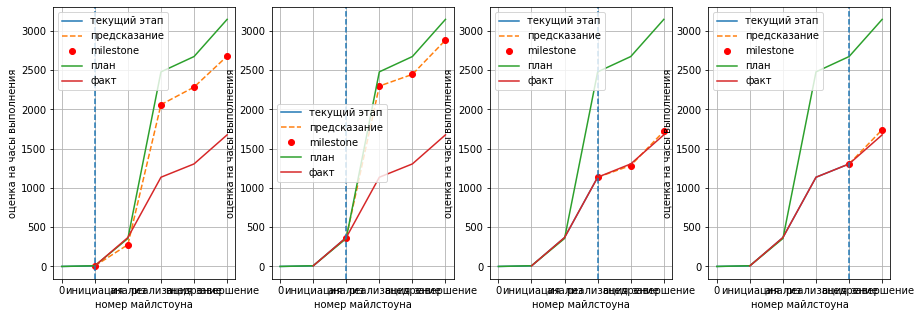

In [6]:
make_predict_chart(data_project, 2, first_c, second_c, third_c, pos)

mistake: 16.447368421052634
mistake: 28.289473684210524
mistake: 21.710526315789476


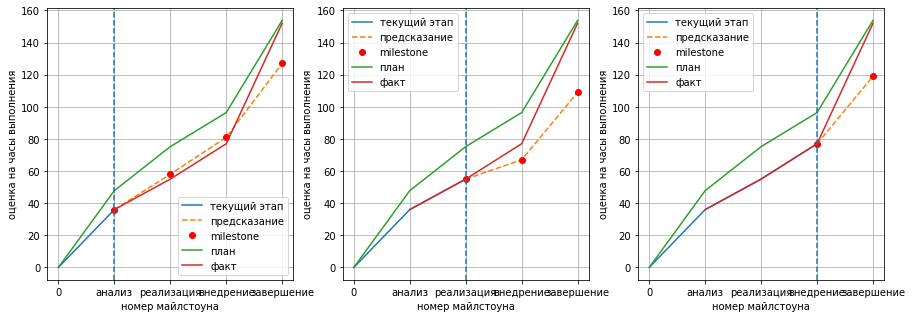

In [7]:
make_predict_chart(data_project, 0, first_c, second_c, third_c, pos)

mistake: 13.715710723192021
mistake: 3.2418952618453867
mistake: 0.3740648379052369


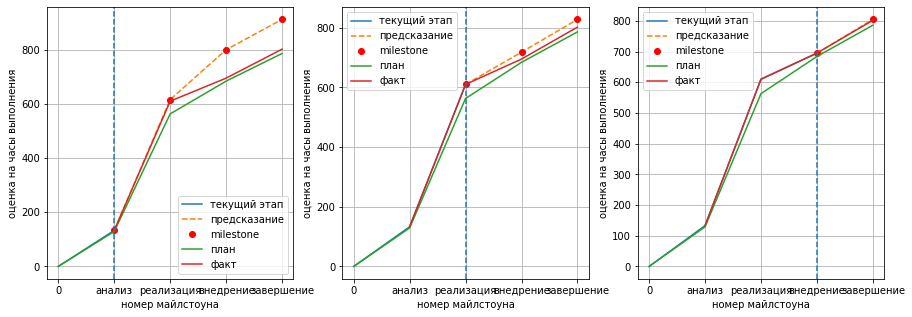

In [8]:
make_predict_chart(data_project, 73, first_c, second_c, third_c, pos)

In [9]:
def mistake(data_project, position, first_c, second_c, third_c, project_lines):

    first_ff = predict_stages(data_project, pos[position], 1, first_c) 
    first = first_ff

    first_second_stage = predict_stages(data_project, pos[position], 2, second_c)
    first_third_stage = predict_stages(data_project, pos[position], 3, third_c)
    
    
    est0 = []
    s = 0
    for x in first_ff['Estimate_hours']:
        s += x
        est0.append(s)
    real0 = []
    s1 = 0
    for x in first['TSM']:
        s1 += x
        real0.append(s1)
    
    inic = abs(est0[-1] - real0[-1]) / real0[-1] * 100
    
    
    est1 = []
    s = sum(first['TSM'][0:2])
    est1.append(s)
    for x in first_second_stage['Estimate_hours'][2:]:
        s += x
        est1.append(s)

    real1 = []
    s1 = 0
    for x in first['TSM']:
        s1 += x
        real1.append(s1)

    
    anal = abs(est1[-1] - real1[-1]) / real1[-1] * 100


    est2 = []
    s = sum(first['TSM'][0:3])
    est2.append(s)
    for x in first_second_stage['Estimate_hours'][3:]:
        s += x
        est2.append(s)

    real2 = []
    s1 = 0
    for x in first['TSM']:
        s1 += x
        real2.append(s1)

    realys = abs(est2[-1] - real2[-1]) / real2[-1] * 100
    
    
    if (len(pos[position]) == 5):

        pl = []
        s = 0
        for i in first['TSM']:
            pl.append(s)
            s += i

        est3 = []
        s = sum(first['TSM'][0:4])
        est3.append(s)
        for x in first_second_stage['Estimate_hours'][4:]:
            s += x
            est3.append(s)

        real3 = []
        s1 = 0
        for x in first['TSM']:
            s1 += x
            real3.append(s1)


        vnedr = abs(est3[-1] - real3[-1]) / real3[-1] * 100
    
    all_stage = []
    all_stage.append(inic)
    all_stage.append(anal)
    all_stage.append(realys)
    if (len(pos[position]) == 5):
        all_stage.append(vnedr)
    return all_stage


### Подготовим данные для визуализации

In [10]:
all_prog = []
for i in range(num_projects):
    all_prog.append(mistake(data_project, i, first_c, second_c, third_c, pos))


In [11]:

inic_st = []
anal_st = []
real_st = []
vnedr_st = []

for i in range(num_projects):
    if len(all_prog[i]) == 3:
        anal_st.append(all_prog[i][0])
        real_st.append(all_prog[i][1])
        vnedr_st.append(all_prog[i][2])
    else:
        inic_st.append(all_prog[i][0])
        anal_st.append(all_prog[i][1])
        real_st.append(all_prog[i][2])
        vnedr_st.append(all_prog[i][3])


### Функция для различных отклонений

In [12]:
def interval(mas):
    cnt_5 = 0
    cnt_5_10 = 0
    cnt_10_20 = 0
    cnt_20_30 = 0
    cnt_30_100 = 0
    ans = []
    for i in range(len(mas)):
        if mas[i] <= 5:
            cnt_5+=1
        elif 5 < mas[i] <= 10:
            cnt_5_10+=1
        elif 10 < mas[i] <= 20:
            cnt_10_20+=1
        elif 20 < mas[i] <= 30:
            cnt_20_30+=1
        else:
            cnt_30_100+=1


    ans.append(cnt_5/len(mas)*100)


    ans.append(cnt_5_10/len(mas)*100)


    ans.append(cnt_10_20/len(mas)*100)


    ans.append(cnt_20_30/len(mas)*100)
    
    ans.append(cnt_30_100/len(mas)*100)

    return ans

## Посчитаем процент на каждый этап, где отклонения находятся в различных диапазонах


In [13]:
procents = pd.DataFrame(['0%-5%','5%-10%','10%-20%','20%-30%','>30%'], columns = ['диапазон'])
df_inic = pd.DataFrame(interval(inic_st), columns = ['кол-во'])
df_anal = pd.DataFrame(interval(anal_st), columns = ['кол-во'])
df_real = pd.DataFrame(interval(real_st), columns = ['кол-во'])
df_vnedr = pd.DataFrame(interval(vnedr_st), columns = ['кол-во'])

df_inic = pd.concat([df_inic,procents], axis = 1)
df_anal = pd.concat([df_anal,procents], axis = 1)
df_real = pd.concat([df_real,procents], axis = 1)
df_vnedr = pd.concat([df_vnedr,procents], axis = 1)



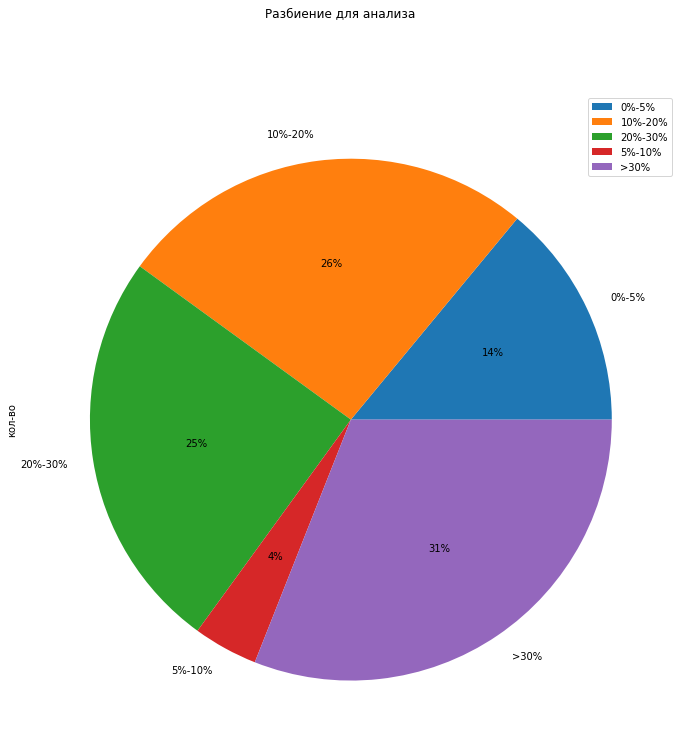

In [14]:
_ = df_anal.groupby(['диапазон']).sum().plot(kind='pie', y='кол-во', autopct='%0.0f%%', title='Разбиение для анализа',subplots=True, figsize=(12, 12))


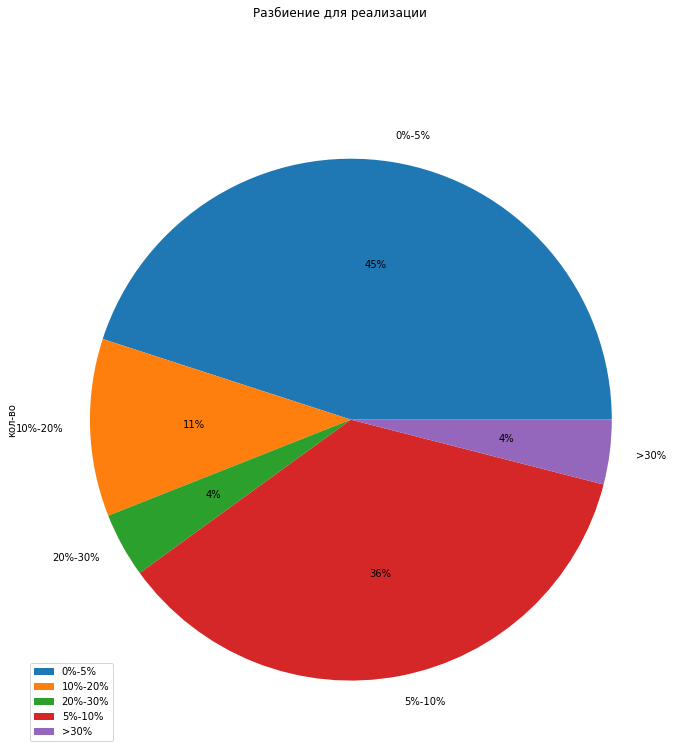

In [15]:
_ = df_real.groupby(['диапазон']).sum().plot(kind='pie', y='кол-во', autopct='%0.0f%%', title='Разбиение для реализации',subplots=True, figsize=(12, 12))


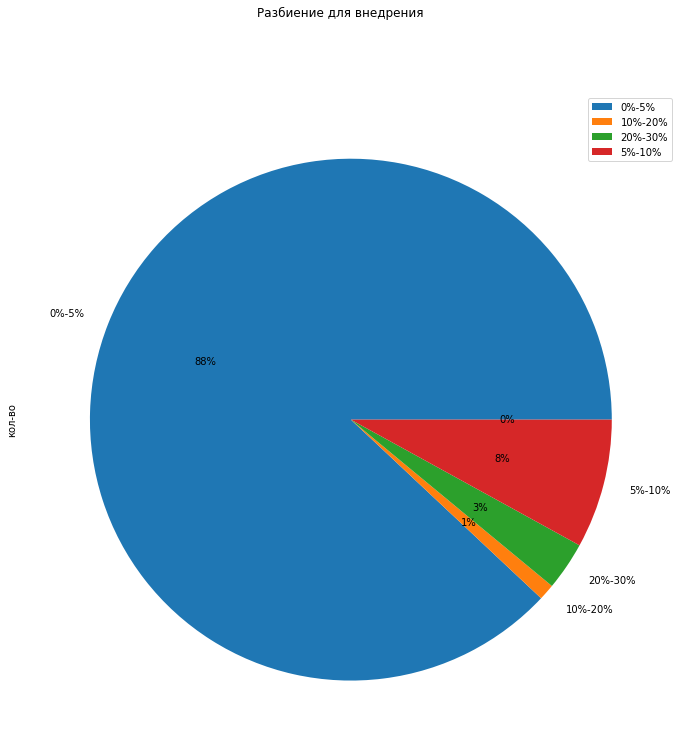

In [16]:
_ = df_vnedr.groupby(['диапазон']).sum().plot(kind='pie', y='кол-во', autopct='%0.0f%%', title='Разбиение для внедрения',subplots=True, figsize=(12, 12))
